# Models for non_text features

Try automl library
TO DO:
- remove outliers from train_data
- ajout nouvelles features: ratio, log ..
- travail sur les features
- réseau neurone
- test deep learning models

In [29]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns







from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack




# Data

In [30]:
# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")




# Remove outliers

TO DO



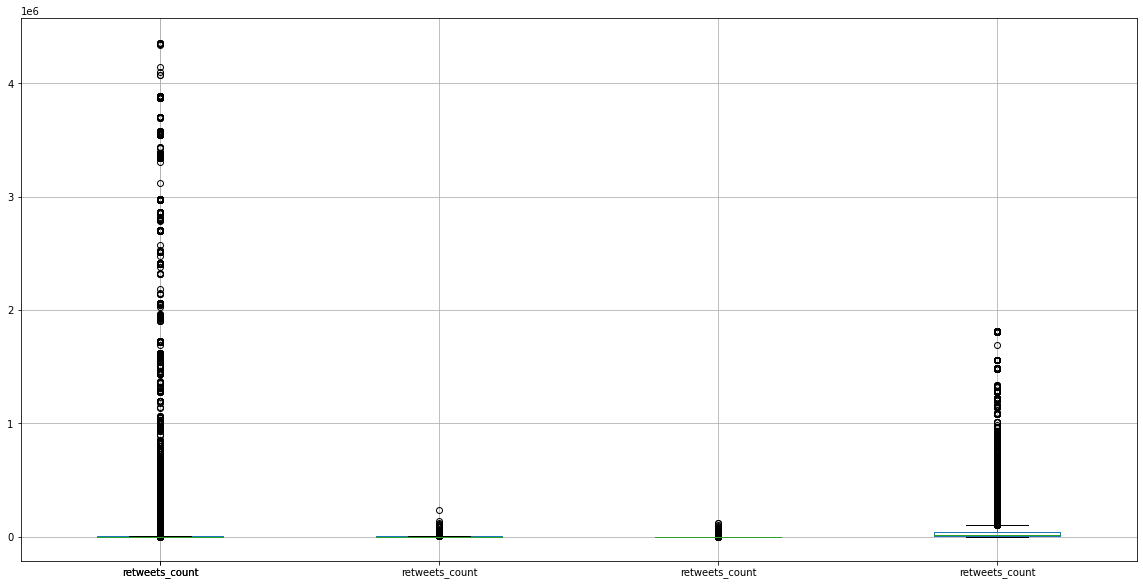

In [37]:
#show outliers
plt.rcParams['figure.figsize'] = [20, 10]
train_data.boxplot(column=['followers_count', 'friends_count', 'favorites_count', 'statuses_count'])
#increase size
plt.rcParams['figure.figsize'] = [20, 10]
train_data.boxplot(column=[ 'retweets_count'])
plt.show()

# remove outliers
train_data = train_data[train_data['followers_count'] < 5000000]
train_data = train_data[train_data['statuses_count'] < 2100000]

# Splitting

In [ ]:
# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)

# Data cleaning

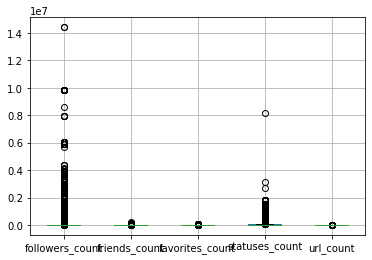

KeyError: "None of [Index(['retweets_count'], dtype='object')] are in the [columns]"

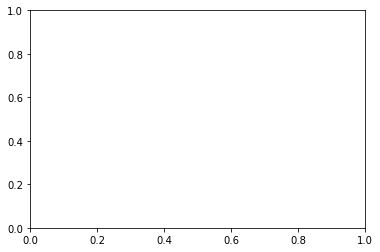

In [10]:
#mentions is always empty -> DROP Mention

X_train = X_train.drop(['mentions'], axis=1)
X_test = X_test.drop(['mentions'], axis=1)

#Tweet id is not relevant -> DROP Tweet id
X_train = X_train.drop(['TweetID'], axis=1)
X_test = X_test.drop(['TweetID'], axis=1)


#add a column to data which counts url
X_train['url_count'] = X_train['urls'].str.count('http')
X_test['url_count'] = X_test['urls'].str.count('http')
X_train = X_train.drop(['urls'], axis=1)
X_test = X_test.drop(['urls'], axis=1)




#drop the text column
X_train = X_train.drop(['text'], axis=1)
X_test = X_test.drop(['text'], axis=1)

#drop the hashtags column
X_train = X_train.drop(['hashtags'], axis=1)
X_test = X_test.drop(['hashtags'], axis=1)



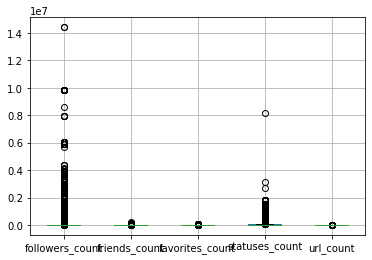

KeyError: "None of [Index(['retweets_count'], dtype='object')] are in the [columns]"

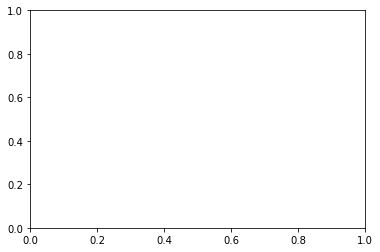

# Pipeline

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
 


pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
pipelines.append(('ScaledMLP', Pipeline([('Scaler', StandardScaler()),('MLP', MLPRegressor())])))



results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -10.538812 (0.886428)
ScaledLASSO: -10.124824 (0.953406)
ScaledEN: -13.899756 (1.088446)
ScaledKNN: -7.218124 (0.799233)
ScaledCART: -8.597397 (0.835062)
ScaledGBM: -6.802502 (0.651244)
ScaledRF: -6.391916 (0.703740)
ScaledMLP: -8.864348 (0.715103)


After 55min: StandardScaler, no extraction, no selection
- ScaledLR: -10.538812 (0.886428)
- ScaledLASSO: -10.124824 (0.953406)
- ScaledEN: -13.899756 (1.088446)
- ScaledKNN: -7.218124 (0.799233)
- ScaledCART: -8.597397 (0.835062)
- ScaledGBM: -6.802502 (0.651244)
- ScaledRF: -6.391916 (0.703740)
- ScaledMLP: -8.864348 (0.715103)

In [6]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
 


pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', MinMaxScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
pipelines.append(('ScaledMLP', Pipeline([('Scaler', MinMaxScaler()),('MLP', MLPRegressor())])))



results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -10.433137 (0.871373)
ScaledLASSO: -20.037637 (1.619121)
ScaledEN: -26.620310 (1.340733)
ScaledKNN: -7.534165 (0.766204)
ScaledCART: -8.391123 (0.749394)
ScaledGBM: -6.639914 (0.724651)
ScaledRF: -6.230696 (0.714884)
ScaledMLP: -8.770942 (0.776259)


 No extraction nor selection, MinMaxScaler

- ScaledLR: -10.433137 (0.871373)
- ScaledLASSO: -20.037637 (1.619121)
- ScaledEN: -26.620310 (1.340733)
- ScaledKNN: -7.534165 (0.766204)
- ScaledCART: -8.391123 (0.749394)
- ScaledGBM: -6.639914 (0.724651)
- ScaledRF: -6.230696 (0.714884)
- ScaledMLP: -8.770942 (0.776259)




Bilan: Min MaxScaler is better
